In [1]:
# imports
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
print('Matplotlib version: ', mpl.__version__)
print(plt.style.available)
mpl.style.use(['ggplot'])

Matplotlib version:  3.0.2
['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [3]:
full_timestamps = ["{:02d}:{:02d}:00".format(hour, minute) for hour in range(24) for minute in range(60)]

In [4]:
with open('../data/subject.pkl', 'rb') as input:
    subjects =  pickle.load(input)
# convert subjects list to dict
subjects_dict = {s.number : s for s in subjects}

In [5]:
# fill missing timestamps with -1 for sleep pattern
for s in subjects:
    for day, df in s.motor_data_days.items():
        df.set_index("timestamp", inplace=True)
        df = df.reindex(full_timestamps).fillna(-1)
        s.motor_data_days[day] = df
        assert len(df['activity']) == 24*60
        df.reset_index(inplace=True)

In [4]:
# get list of patient id and corresponding available days
id_days = ""
for s in subjects:
    id_days += ("{:<10}".format(s.number) + '\n' + ' '.join(s.motor_data_days.keys()) + '\n')
with open('../record/id_days.txt', 'w') as f:
    f.write(id_days)

In [43]:
# sleep pattern
dfs = [s.motor_data_df for s in subjects]
full_df = pd.concat(dfs, axis=0)
full_timestamps = ["{:02d}:{:02d}:00".format(hour, minute) for hour in range(24) for minute in range(60)]
# sleep: 11pm - 7:59am
sleep_timestamps = ["{:02d}:{:02d}:00".format(hour, minute) for hour in list(range(23, 24)) + list(range(0, 8)) for minute in range(60)]
non_sleep_timestamps = list(set(full_timestamps) - set(sleep_timestamps))
full_df = full_df.set_index('timestamp')
sleep_df = full_df.loc[sleep_timestamps, :]
non_sleep_df = full_df.loc[non_sleep_timestamps, :]
assert (len(sleep_df) + len(non_sleep_df)) == len(full_df)
mean_sleep_activity = sleep_df['activity'].mean()
mean_non_sleep_activity = non_sleep_df['activity'].mean()

print('mean_sleep_activity', mean_sleep_activity)
print('mean_non_sleep_activity', mean_non_sleep_activity)

mean_sleep_activity 69.53650908236528
mean_non_sleep_activity 245.21714232307522


In [6]:
def get_sleep_pattern_from_array(x, threshold=300):
    # reset timestamp, start from noon, end at 11:59am
    x = np.roll(x, 12 * 60)
    rolled_timestamps = np.roll(np.array(full_timestamps), 12 * 60)
    # convert to binary array
    x = np.where(x <= threshold, 1, 0)
    max_count, start_index, end_index = get_longest_consecutive_ones(x)
    
    return max_count + 1, rolled_timestamps[start_index], rolled_timestamps[end_index]

def get_longest_consecutive_ones(x):
    max_count = 0
    cur_count = 0
    max_end_index = 0

    for index, num in enumerate(x):
        if num == 1:
            cur_count += 1
        elif num == 0:
            if cur_count > max_count:
                max_count = cur_count
                max_end_index = index - 1
            cur_count = 0

    return (max_count, max_end_index - max_count + 1, max_end_index)

In [104]:
#from feature_gen import get_sleep_pattern_from_array, get_longest_consecutive_ones
name = 'control_2'
date = '2002-10-02'
activity = subjects_dict[name].motor_data_days[date]['activity'].tolist()
activity = np.array(activity)

print(get_sleep_pattern_from_array(activity))

(195, '12:00:00', '15:13:00')


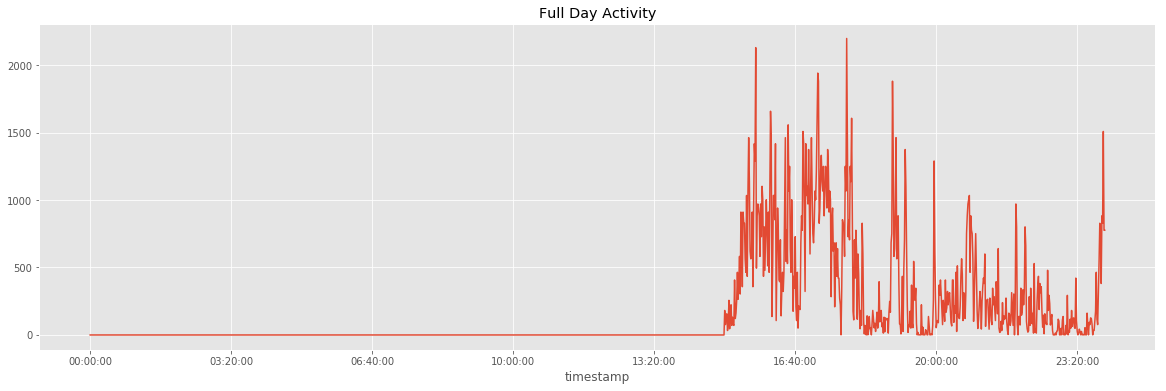

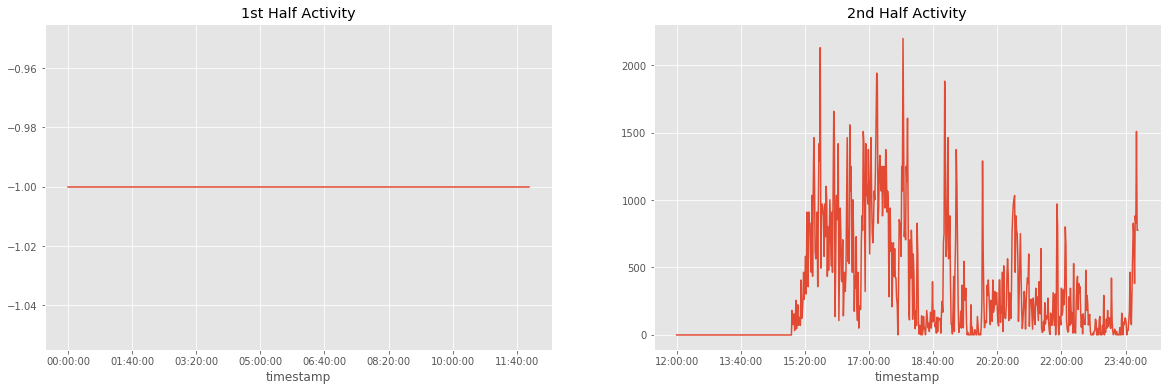

In [105]:
plot_daily_activity(name, date)

In [16]:
# get sleep patterns for all subjects
condition = []
control = []
for s in subjects:
    for day, df in s.motor_data_days.items():
        activity = df['activity'].tolist()
        activity = np.array(activity)
        length, start, end = list(get_sleep_pattern_from_array(activity))
        sleep_pattern = list(get_sleep_pattern_from_array(activity))
        print(sleep_pattern)
        sleep_pattern = [int(length), int(start[:2]), int(end[:2])]
        if s.number[3] == 't':
            control.append(sleep_pattern)
        else:
            condition.append(sleep_pattern)
condition = np.array(condition)
control = np.array(control)

[105, '20:27:00', '22:10:00']
[502, '23:46:00', '08:06:00']
[398, '01:59:00', '08:35:00']
[288, '02:16:00', '07:02:00']
[288, '23:27:00', '04:13:00']
[584, '23:25:00', '09:07:00']
[237, '03:25:00', '07:20:00']
[186, '23:22:00', '02:26:00']
[232, '01:34:00', '05:24:00']
[147, '02:40:00', '05:05:00']
[482, '01:47:00', '09:47:00']
[282, '02:13:00', '06:53:00']
[700, '19:53:00', '07:31:00']
[630, '23:24:00', '09:52:00']
[431, '00:18:00', '07:27:00']
[367, '14:04:00', '20:09:00']
[159, '12:00:00', '14:37:00']
[182, '16:46:00', '19:46:00']
[138, '01:50:00', '04:06:00']
[174, '21:43:00', '00:35:00']
[209, '18:58:00', '22:25:00']
[311, '20:54:00', '02:03:00']
[227, '00:39:00', '04:24:00']
[502, '18:56:00', '03:16:00']
[284, '16:59:00', '21:41:00']
[269, '21:02:00', '01:29:00']
[305, '21:36:00', '02:39:00']
[318, '18:27:00', '23:43:00']
[332, '23:58:00', '05:28:00']
[267, '12:50:00', '17:15:00']
[179, '20:25:00', '23:22:00']
[186, '15:59:00', '19:03:00']
[209, '19:21:00', '22:48:00']
[149, '02:

[1162, '12:00:00', '07:20:00']
[700, '22:13:00', '09:51:00']
[412, '02:50:00', '09:40:00']
[229, '04:01:00', '07:48:00']
[361, '05:53:00', '11:52:00']
[413, '04:27:00', '11:18:00']
[197, '07:49:00', '11:04:00']
[518, '01:02:00', '09:38:00']
[420, '23:52:00', '06:50:00']
[244, '03:25:00', '07:27:00']
[445, '01:25:00', '08:48:00']
[534, '01:02:00', '09:54:00']
[437, '03:45:00', '11:00:00']
[251, '02:28:00', '06:37:00']
[200, '00:58:00', '04:16:00']
[513, '15:31:00', '00:02:00']
[1138, '12:00:00', '06:56:00']
[79, '19:58:00', '21:15:00']
[141, '09:23:00', '11:42:00']
[286, '06:23:00', '11:07:00']
[124, '12:46:00', '14:48:00']
[99, '07:29:00', '09:06:00']
[86, '08:10:00', '09:34:00']
[128, '12:00:00', '14:06:00']
[196, '20:33:00', '23:47:00']
[134, '22:14:00', '00:26:00']
[215, '12:00:00', '15:33:00']
[195, '07:45:00', '10:58:00']
[182, '06:15:00', '09:15:00']
[177, '18:26:00', '21:21:00']
[191, '20:11:00', '23:20:00']
[581, '15:30:00', '01:09:00']
[1154, '12:00:00', '07:12:00']
[157, '12:

[982, '15:35:00', '07:55:00']
[102, '12:00:00', '13:40:00']
[1, '12:01:00', '12:00:00']
[61, '12:00:00', '12:59:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1353, '12:00:00', '10:31:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1186, '12:00:00', '07:44:00']
[186, '12:00:00', '15:04:00']
[131, '05:23:00', '07:32:00']
[116, '04:56:00', '06:50:00']
[142, '03:24:00', '05:44:00']
[160, '00:47:00', '03:25:00']
[236, '04:24:00', '08:18:00']
[217, '00:39:00', '04:14:00']
[209, '23:42:00', '03:09:00']
[185, '04:29:00', '07:32:00']
[238, '03:12:00', '07:08:00']
[379, '00:46:00', '07:03:00']
[188, '02:39:00', '05:45:00']
[110, '05:42:00', '07:30:00']
[430, '01:07:00', '08:15:00']
[288, '19

[335, '21:44:00', '03:17:00']
[327, '23:37:00', '05:02:00']
[220, '00:19:00', '03:57:00']
[184, '00:47:00', '03:49:00']
[175, '03:13:00', '06:06:00']
[229, '02:32:00', '06:19:00']
[395, '22:24:00', '04:57:00']
[209, '01:02:00', '04:29:00']
[319, '21:46:00', '03:03:00']
[142, '23:54:00', '02:14:00']
[150, '23:01:00', '01:29:00']
[285, '01:54:00', '06:37:00']
[272, '22:43:00', '03:13:00']
[947, '12:00:00', '03:45:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[1, '12:01:00', '12:00:00']
[623, '23:35:00', '09:56:00']
[1197, '12:00:00', '07:55:00']
[638, '23:57:00', '10:33:00']
[199, '01:47:00', '05:04:00']
[127, '09:05:00', '11:10:00']
[71, '14:37:00', '15:46:00']
[459, '03:23:00', '11:00:00']
[232, '02:43:00', '06:33:00']
[262, '05:19:00', '09:39:00']
[100, '12:00:00', '13:38:00']
[182, '12:08:00', '15:08:00']
[246, '12:00:00', '16:04:00']
[519, '03:20:00', '11:57:00']
[400, '03:04:00', '09:

<BarContainer object of 22 artists>

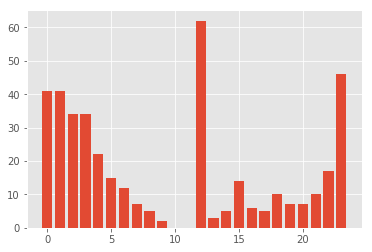

In [10]:
cond_len, cond_start, cond_end = np.apply_along_axis(lambda x : Counter(x), 0, condition)
cont_len, cont_start, cont_end = np.apply_along_axis(lambda x : Counter(x), 0, control)
plt.bar(cond_start.keys(), cond_start.values())


<BarContainer object of 22 artists>

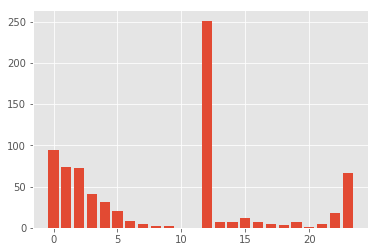

In [11]:
plt.bar(cont_start.keys(), cont_start.values())

<BarContainer object of 24 artists>

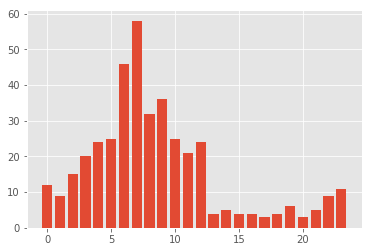

In [12]:
plt.bar(cond_end.keys(), cond_end.values())

<BarContainer object of 24 artists>

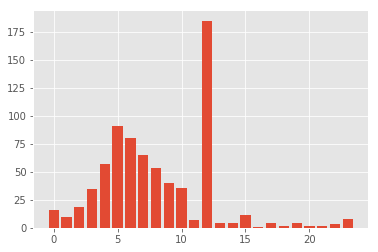

In [13]:
plt.bar(cont_end.keys(), cont_end.values())

In [37]:
# observe general trends for individual subject in the span of one day, activity level = minute
def plot_daily_activity(patient_id, date):
    activity_df = subjects_dict[patient_id].motor_data_days.get(date)
    #activity_df.set_index('timestamp', inplace=True)
    activity_df.plot(kind='line', x='timestamp', y='activity', figsize=(20, 6), title='Full Day Activity', legend=False)
    #plt.savefig('../record/plots/individual/{}-{}.jpeg'.format(patient_id, date))
    # too compact, separate into two halves
    midpoint = len(activity_df) // 2  # round down
    first_half = activity_df[:midpoint] 
    second_half = activity_df[midpoint:]
    assert len(first_half) + len(second_half) == len(activity_df)
    fig = plt.figure()
    ax0 = fig.add_subplot(1, 2, 1) 
    ax1 = fig.add_subplot(1, 2, 2)
    
    first_half.plot(kind='line', x='timestamp', y='activity', figsize=(20,6), title='1st Half Activity', legend=False, ax=ax0)
    second_half.plot(kind='line', x='timestamp', y='activity', figsize=(20,6), title='2nd Half Activity', legend=False, ax=ax1)
    activity_df.reset_index(inplace=True)
    

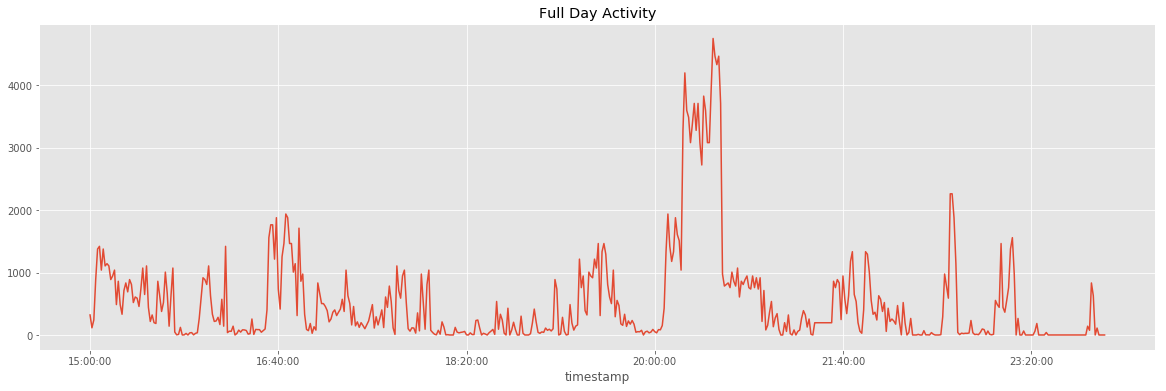

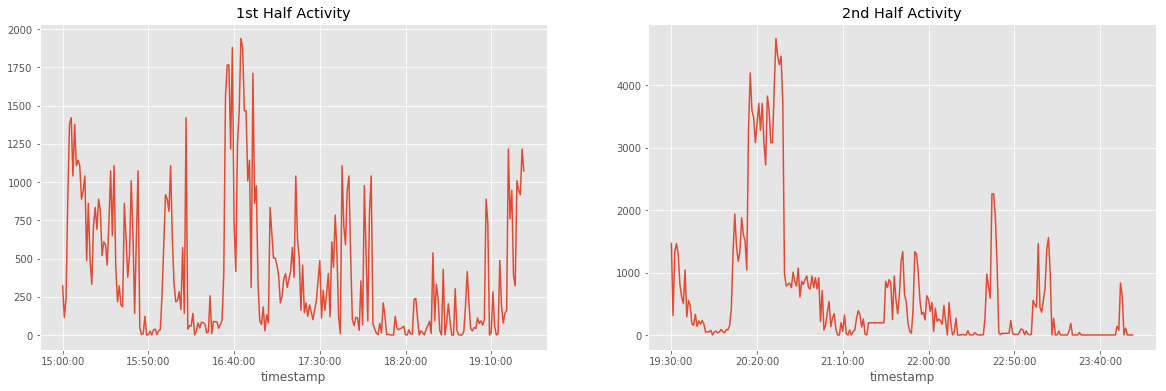

In [25]:
plot_daily_activity('control_31', '2003-03-18')

In [6]:
# compare general trends between two subjects in the span of one day, activity_level = minute
def plot_compare(subject_1, subject_1_date, subject_2, subject_2_date, plot_number=4):
    subject_1_df = subjects_dict[subject_1].motor_data_days.get(subject_1_date)
    subject_2_df = subjects_dict[subject_2].motor_data_days.get(subject_2_date)
    # rename column names
    subject_1_df = subject_1_df.rename(columns={'activity':'{} activity'.format(subject_1)}).set_index('timestamp')
    subject_2_df = subject_2_df.rename(columns={'activity':'{} activity'.format(subject_2)}).set_index('timestamp')
    # may have different time range, only plot intersection timestamp
    intersection_timestamp = list(set(subject_1_df.index).intersection(set(subject_2_df.index)))
    subject_1_df = subject_1_df.loc[intersection_timestamp, :]
    subject_2_df = subject_2_df.loc[intersection_timestamp, :]
    plot_df = pd.concat([subject_1_df, subject_2_df], axis=1) 
    split_point = len(plot_df) // plot_number
    split_df = [plot_df[i * split_point : (i + 1) * split_point] for i in range(plot_number)]
    #plot_df.plot(kind='line', figsize=(20, 6)) # too cramped
    #plt.legend(loc='upper right')
    # first_half_df.plot(kind='line', figsize=(8, 6), alpha=0.8)
    # second_half_df.plot(kind='line', figsize=(8, 6))
    # split into 4 parts, fit into one figure
    fig = plt.figure(figsize=(45, 10))
    axes = [fig.add_subplot(2, 2, i+1) for i in range(plot_number)]
    for i, df in enumerate(split_df):
        df.plot(kind='line', figsize=(20,9), ax=axes[i], xlabel='Timestamp', ylabel='Activity', alpha=0.9)
        axes[i].legend(loc='upper left')

        
    

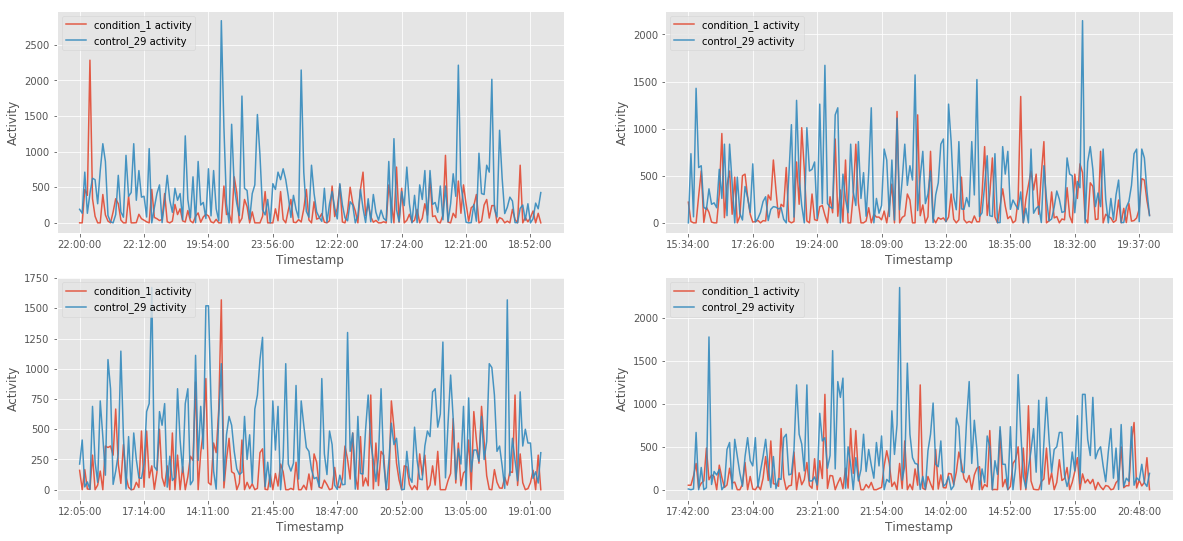

In [7]:
plot_compare('condition_1', '2003-05-07', 'control_29', '2006-01-15')

In [27]:
# trends in individuals' min activity levels over the span of multiple days 
def plot_multiday_activity(subject):
    subject_df = subjects_dict[subject].motor_data_df
    # compute activity mean by day
    daily_mean_df = subject_df.groupby('date')['activity'].mean()
    daily_mean_df.plot(kind='line', figsize=(20,6), 
                       ylabel='mean activity level per minute', title='{} Daily Mean Acitivity'.format(subject))
    

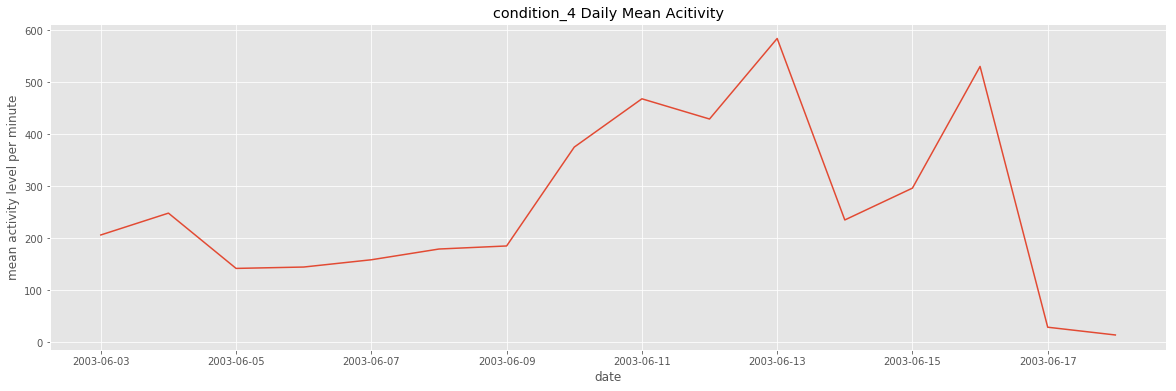

In [33]:
plot_multiday_activity('condition_4')

In [113]:
condition_subjects = [s for s in subjects if s.label == 'condition']
control_subjects = [s for s in subjects if s.label == 'control']
assert len(condition_subjects) == 23 
assert len(control_subjects) == 32

In [382]:
def comparison(mode):
    if mode == 'max-minute':
        # max activity level of each individual, compare between groups
        condition_max = [max(s.motor_data_df['activity']) for s in condition_subjects]
        control_max = [max(s.motor_data_df['activity']) for s in control_subjects]    
        print("Mean max of condition group: {:.2f}".format(np.mean(condition_max)))
        print("Mean max of control group:   {:.2f}".format(np.mean(control_max)))
        plt.figure(figsize=(8,6))
        plt.hist(condition_max, bins=20, alpha=0.5, label='condition')
        plt.hist(control_max, bins=20, alpha=0.5, label='control')
        plt.legend(loc='upper left')
        plt.title('Minute Max Activity Distribution')
    elif mode == 'min-minute':
        # min activity level of each individual, compare between groups
        condition_min = [min(s.motor_data_df['activity']) for s in condition_subjects]
        control_min = [min(s.motor_data_df['activity']) for s in control_subjects]    
        print("Mean min of condition group: {:.2f}".format(np.mean(condition_min)))
        print("Mean min of control group:   {:.2f}".format(np.mean(control_min)))
        plt.figure(figsize=(8,6))
        plt.hist(condition_min, bins=10, alpha=0.5, label='condition')
        plt.hist(control_min, bins=10, alpha=0.5, label='control')
        plt.legend(loc='upper right')
        plt.title('Minute Min Activity Distribution')
    elif mode == 'mean-hour':
        # mean activity level for each hour, compare between groups
        condition_dfs = [s.motor_data_df for s in condition_subjects]
        control_dfs = [s.motor_data_df for s in control_subjects]
        condition_df = pd.concat(condition_dfs, axis=0)
        control_df = pd.concat(control_dfs, axis=0)
        condition_df = condition_df.rename(columns={'activity':'condition activity'})
        control_df = control_df.rename(columns={'activity':'control activity'})
        condition_df['hour'] = condition_df['timestamp'].apply(lambda x : x[:2])
        control_df['hour'] = control_df['timestamp'].apply(lambda x : x[:2])
        condition_mean = condition_df.groupby('hour')['condition activity'].mean() # default ignore nan
        control_mean = control_df.groupby('hour')['control activity'].mean()
        plot_df = pd.concat([condition_mean, control_mean], axis=1)
        plot_df.plot(kind='bar', color=['coral', 'mediumseagreen'], alpha=0.7, figsize=(20,6), title='Mean Activity per Hour Comparison between Two Groups')
    elif mode == 'percentage no activity':
        # percentage of no activity by minute 
        condition_dfs = []
        control_dfs = []
        for s1, s2 in zip(condition_subjects, control_subjects):
            condition_dfs.extend(list(s1.motor_data_days.values()))
            control_dfs.extend(list(s2.motor_data_days.values()))
        condition_count = list(map(get_percentage, condition_dfs))
        control_count = list(map(get_percentage, control_dfs))
        plot_df = pd.DataFrame({'condition': pd.Series(condition_count), 'control': pd.Series(control_count)})
        # comparison box plot
        print(plot_df.describe())
        plot_df.plot(kind='box', figsize=(8,8), 
                     title='No Activity Percentage Boxplots for Condition and Control')
    elif mode == 'bedtime':
        # distribution of bedtime
        #TODO: compute bedtime
        pass
        
def add_hour_col(df):
    df['hour'] = df['timestamp'].apply(lambda x : x[:2])
    
    
def get_percentage(df):
    return sum(df['activity'] == 0) / len(df)

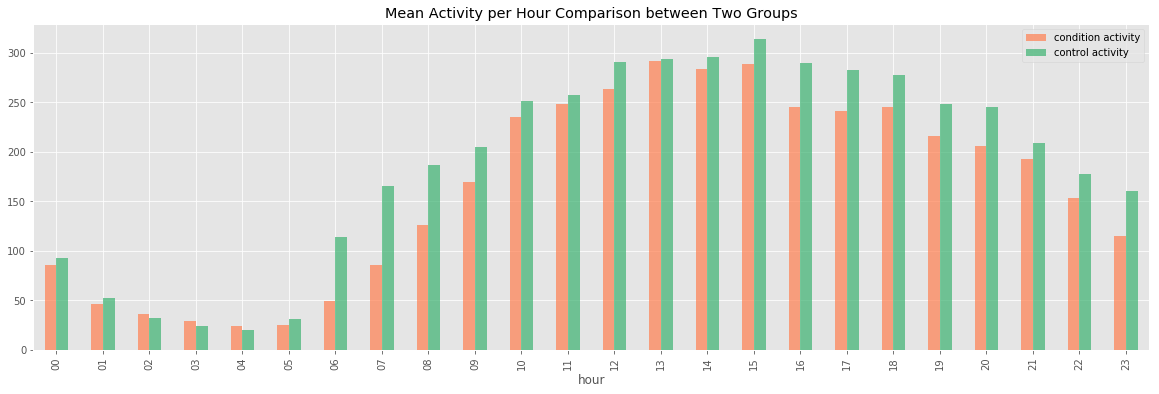

In [383]:
comparison('mean-hour')

        condition     control
count  405.000000  542.000000
mean     0.435628    0.388441
std      0.250433    0.298524
min      0.000000    0.000000
25%      0.324306    0.233681
50%      0.409028    0.328472
75%      0.568750    0.447396
max      1.000000    1.000000


/Users/phichitchulanont/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


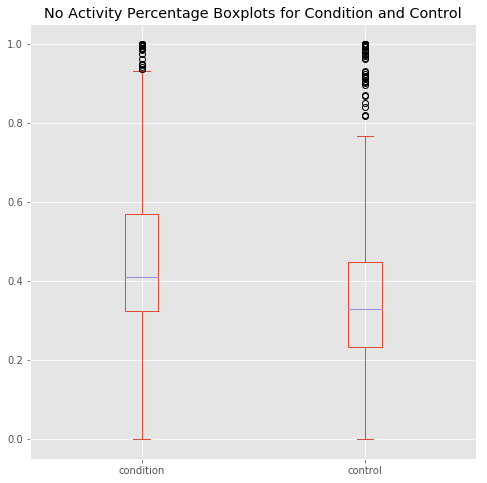

In [366]:
comparison('percentage no activity')

In [264]:
def compare_by_hour(subject_1, subject_2):
    subject_1_df = subjects_dict[subject_1].motor_data_df
    subject_2_df = subjects_dict[subject_2].motor_data_df
    subject_1_df = subject_1_df.rename(columns={'activity':'{} activity'.format(subject_1)})
    subject_2_df = subject_2_df.rename(columns={'activity':'{} activity'.format(subject_2)})
    subject_1_df['hour'] = subject_1_df['timestamp'].apply(lambda x : x[:2])
    subject_2_df['hour'] = subject_2_df['timestamp'].apply(lambda x : x[:2])
    s1_hour_mean = subject_1_df.groupby('hour')['{} activity'.format(subject_1)].mean() 
    s2_hour_mean = subject_2_df.groupby('hour')['{} activity'.format(subject_2)].mean()
    plot_df = pd.concat([s1_hour_mean, s2_hour_mean], axis=1)
    plot_df.plot(kind='bar', color=['coral', 'mediumseagreen'], alpha=0.7, figsize=(20,6), title='Mean Activity per Hour Comparison between Two Subjects')
    

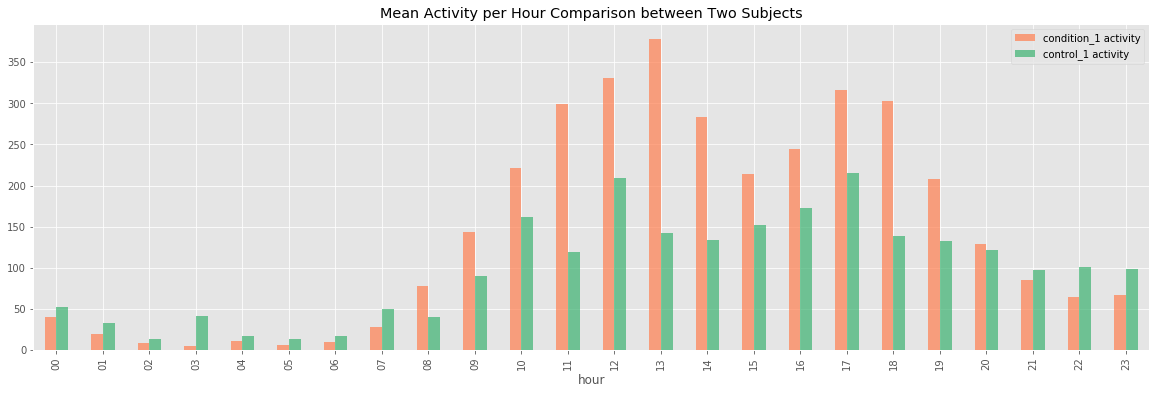

In [273]:
compare_by_hour('condition_1', 'control_1')